# Verbatim compilation

Usually, when you run a circuit on a QPU, behind the scenes, Amazon Braket will do a series of compilation steps to optimize your circuit and map the abstract circuit to the physical qubits on the QPU. However, in many situations,  such as for error mitigation or benchmarking experiments, researchers require full control of the qubits and the gates that are being applied. In a [previous notebook](https://github.com/aws/amazon-braket-examples/blob/main/examples/braket_features/Allocating_Qubits_on_QPU_Devices.ipynb), we showed you how to manually allocate the qubits of your circuit, i.e., how you can exactly define which logical qubit maps to which physical qubit. In this notebook, you will learn how to use _verbatim compilation_ to run your circuits exactly as defined without any modification during the compilation process.

Let us begin with importing the usual dependencies. Verbatim compilation is supported by all Rigetti devices, and we will use the Aspen-9 device for this demonstration. As usual, we select an S3 bucket to store our results in. Remember that bucket names for Amazon Braket always begin with "amazon-braket-".

In [1]:
# general imports
import boto3
from braket.aws import AwsDevice
from braket.circuits import Circuit
from math import pi
import networkx as nx


# define the location where task results will be stored
my_bucket = "<Your-Bucket-Name>" # you must replace this string with the name of your S3 bucket.
my_prefix = "verbatim-compilation-demo" # you can choose a different folder name if you like

s3_folder = (my_bucket, my_prefix)

# set up the Rigetti Aspen-9 device
rigetti = AwsDevice("arn:aws:braket:::device/qpu/rigetti/Aspen-9")

## Recap: Running circuits on Amazon Braket

When you run a circuit on Amazon Braket, different compilation and optimization steps occur before the circuit is executed on the selected QPU. First, the gates of your circuit are decomposed into the _native gates_ of the QPU. Let's first remember what the native gates of the Aspen-9 device are:

In [2]:
rigetti.properties.paradigm

GateModelQpuParadigmProperties(braketSchemaHeader=BraketSchemaHeader(name='braket.device_schema.gate_model_qpu_paradigm_properties', version='1'), connectivity=DeviceConnectivity(fullyConnected=False, connectivityGraph={'0': ['1', '7'], '1': ['0', '16'], '10': ['11', '17'], '11': ['10', '12', '26'], '12': ['11', '13', '25'], '13': ['12', '14'], '14': ['13', '15'], '15': ['14', '2'], '16': ['1', '17'], '17': ['10', '16'], '2': ['15', '3'], '20': ['21', '27'], '21': ['20', '22', '36'], '22': ['21', '23', '35'], '23': ['22', '24'], '24': ['23', '25'], '25': ['12', '24', '26'], '26': ['11', '25', '27'], '27': ['20', '26'], '3': ['2', '4'], '30': ['31', '37'], '31': ['30', '32'], '32': ['31', '33'], '33': ['32', '34'], '34': ['33', '35'], '35': ['22', '34', '36'], '36': ['21', '35', '37'], '37': ['30', '36'], '4': ['3', '5'], '5': ['4', '6'], '6': ['5', '7'], '7': ['0', '6']}), qubitCount=32, nativeGateSet=['RX', 'RZ', 'CZ', 'CPHASE', 'XY'])

In [3]:
# list the native gate set
print("The native gates for the", rigetti.name, "device are:")
for gate in rigetti.properties.paradigm.nativeGateSet:
    print(gate)

The native gates for the Aspen-9 device are:
RX
RZ
CZ
CPHASE
XY


If we create a circuit with gates that are not part of that list, the gates will automatically be decomposed into a gate set that can be executed on the device.

<div class="alert alert-block alert-info">
    <b>Note:</b> This notebook uses the Rigetti Aspen-9 device. When you run this notebook, make sure the device is currently available. You can find QPU availability windows on the <a href="https://us-west-1.console.aws.amazon.com/braket/home?region=us-west-1#/devices">Devices page</a> in the Amazon Braket Console
</div>

In [4]:
bell = Circuit().h(100).cnot(100,101)
print(bell)
result = rigetti.run(bell, s3_folder, shots=1000).result()
print(result.measurement_counts)

T    : |0|1|
            
q100 : -H-C-
          | 
q101 : ---X-

T    : |0|1|
Counter({'00': 458, '11': 443, '10': 63, '01': 36})


Let's have a look at the circuit that was actually executed. 

In [5]:
meta = result.additional_metadata.rigettiMetadata
print(meta.compiledProgram)

DECLARE ro BIT[2]
PRAGMA INITIAL_REWIRING "PARTIAL"
RESET
RZ(pi/2) 10
RX(pi/2) 10
RZ(-pi/2) 17
RX(pi/2) 17
CZ 17 10
RZ(-pi/2) 10
RX(-pi/2) 17
RZ(pi/2) 17
MEASURE 17 ro[1]
MEASURE 10 ro[0]



As you can see, the original gates, `h` and `cnot`, were decomposed into the native `rz`, `rx`, `cz`, and `cphase` gates. You will also note that the abstract qubit indices 100 and 101 (which were chosen as an example) were remapped to qubits that actually exist on the device, in this case, 21 and 36, respectively. At the time when you run this notebook, you might see a different remapping, as the compiler takes into account the latest calibration of the device and tries to map to the qubits that yield the best results. 

The compiler further performs circuit optimizations to minimize the number of operations, e.g., by removing redundant gates. Let's have a look at a single-qubit circuit containing two subsequent `x` gates:

In [6]:
identity = Circuit().x(0).x(0)

Of course, if you do the math, two consecutive `x` gates just cancel each other out, and we are left with an empty circuit after compilation.

In [7]:
result = rigetti.run(identity, s3_folder, shots=1000).result()
compiled_program = result.additional_metadata.rigettiMetadata.compiledProgram
print(compiled_program)
print(result.measurement_counts)

DECLARE ro BIT[1]
PRAGMA INITIAL_REWIRING "PARTIAL"
RESET
MEASURE 32 ro[0]

Counter({'0': 889, '1': 111})


## Using verbatim compilation to run circuits without further compilation

In some cases, however, you may need to run circuits exactly as defined, without any further modifications by the compiler. For instance, if you want to benchmark device performance you may want to control exactly which gates are executed on the hardware. Similarly, [certain error mitigation protocols](https://arxiv.org/pdf/2005.10921.pdf) require insertion of additional, redundant operations that would normally be removed by the compiler but are essential for the protocol to work. To prevent circuits (or parts of circuits) from further compiler optimizations, you can use the `add_verbatim_box` function in the Amazon Braket SDK.

<div class="alert alert-block alert-info">
    <b>Note:</b> <code>add_verbatim_box</code> is currently only supported on Rigetti devices.
</div>

When you define a (sub-)circuit in a verbatim box, you need to make sure that everything inside the verbatim box can be executed on the device _exactly_ as you defined it. This means that
1. The circuit can only use qubit indices that exist on the device
2. All gates of the circuit have to be part of the native gate set of the device
3. All multi-qubit gates have to be between qubits that are connected according to the connectivity graph of the device 

### Getting started with a minimal example
Let's have a look at the simple example from before of an identify circuit. 

In [8]:
identity = Circuit().rx(0,pi).rx(0,pi)

Here, we have chosen the Rigetti-native `rx` gate, which is identical to `x` if we choose the angle to be $\pi$. Next, we wrap this circuit in a verbatim box to prevent the compiler from collapsing the two gates. You can see the circuit diagram indicates the start and end of the verbatim box.

In [9]:
circ = Circuit().add_verbatim_box(identity)
print(circ)

T  : |      0      |   1    |   2    |     3     |
                                                  
q0 : -StartVerbatim-Rx(3.14)-Rx(3.14)-EndVerbatim-

T  : |      0      |   1    |   2    |     3     |


When we run the circuit, both gates will be executed on the device.

<div class="alert alert-block alert-info">
    <b>Note:</b> To run a circuit that contains a verbatim box the <code>disable_qubit_rewiring</code> flag must be set to <code>True</code> 
</div>

In [11]:
result = rigetti.run(circ, s3_folder, shots=1000, disable_qubit_rewiring=True).result()
compiled_program = result.additional_metadata.rigettiMetadata.compiledProgram
print(compiled_program)
print(result.measurement_counts)

DECLARE ro BIT[1]
PRAGMA INITIAL_REWIRING "NAIVE"
RX(pi) 0
RX(pi) 0
MEASURE 0 ro[0]

Counter({'0': 912, '1': 88})


### Programming verbatim circuits onto the device topology

As we have mentioned above, to build circuits with multi-qubit gates, you need to take into consideration the connectivity graph of the device. When a circuit contains a verbatim box, automatic qubit rewiring has to be disables, and you have manually allocate the qubits on the device that you want to use for your circuit.
You can access the connectivity graph on the [device detail page](https://console.aws.amazon.com/braket/home?region=us-east-1#/devices/arn:aws:braket:::device/qpu/rigetti/Aspen-9) in the Amazon Braket Console, or by using the code below.

{'0': ['1', '7'], '1': ['0', '16'], '10': ['11', '17'], '11': ['10', '12', '26'], '12': ['11', '13', '25'], '13': ['12', '14'], '14': ['13', '15'], '15': ['14', '2'], '16': ['1', '17'], '17': ['10', '16'], '2': ['15', '3'], '20': ['21', '27'], '21': ['20', '22', '36'], '22': ['21', '23', '35'], '23': ['22', '24'], '24': ['23', '25'], '25': ['12', '24', '26'], '26': ['11', '25', '27'], '27': ['20', '26'], '3': ['2', '4'], '30': ['31', '37'], '31': ['30', '32'], '32': ['31', '33'], '33': ['32', '34'], '34': ['33', '35'], '35': ['22', '34', '36'], '36': ['21', '35', '37'], '37': ['30', '36'], '4': ['3', '5'], '5': ['4', '6'], '6': ['5', '7'], '7': ['0', '6']}


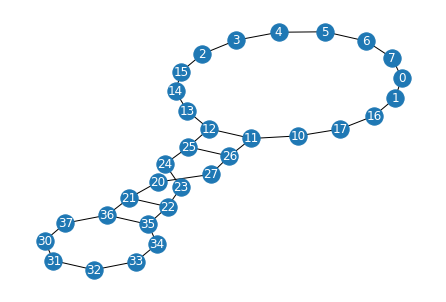

In [12]:
# access and visualize the device topology
print(rigetti.properties.paradigm.connectivity.connectivityGraph)
nx.draw_kamada_kawai(rigetti.topology_graph, with_labels=True, font_color="white")

From the connectivity graph, you can see that qubits 11, 10, and 17 are connected in a line, and with the code in the next cell you can access their respective 2-qubit gate fidelities to make sure you have selected a high-quality qubit subset. 

In [13]:
print(rigetti.properties.provider.specs["2Q"]["10-11"])
print(rigetti.properties.provider.specs["2Q"]["10-17"])

{'fCPHASE': 0.9370584109675574, 'fCPHASE_std_err': 0.00795074764345174, 'fCZ': 0.9299243089381443, 'fCZ_std_err': 0.014825613277350928, 'fXY': 0.9745254923082562, 'fXY_std_err': 0.008192514619096408}
{'fCPHASE': 0.9814191643655765, 'fCPHASE_std_err': 0.003640156618078282, 'fCZ': 0.9901793460716128, 'fCZ_std_err': 0.002845237063339863, 'fXY': 0.9619550297476629, 'fXY_std_err': 0.005187344784704715}


<div class="alert alert-block alert-info">
    <b>Note:</b> At the time when you run this notebook the fidelity numbers may be different as QPU devices are periodically recalibrated
</div>

After selecting the qubits and validating their gate fidelities, you can now construct a cirucit and run it. 

In [14]:
circ = Circuit().xy(10,11,pi/4).xy(10,17,pi/2).rx(10,pi).xy(10,11,pi/4)
verbatim_circ = Circuit().add_verbatim_box(circ)
print(verbatim_circ)

T   : |      0      |    1    |   2    |   3    |    4    |     5     |
                                                                       
q10 : -StartVerbatim-XY(0.785)-XY(1.57)-Rx(3.14)-XY(0.785)-EndVerbatim-
       |             |         |                 |         |           
q11 : -|-------------XY(0.785)-|-----------------XY(0.785)-|-----------
       |                       |                           |           
q17 : -*************-----------XY(1.57)--------------------***********-

T   : |      0      |    1    |   2    |   3    |    4    |     5     |


In [15]:
result = rigetti.run(verbatim_circ, s3_folder, shots=1000, disable_qubit_rewiring=True).result()
compiled_program = result.additional_metadata.rigettiMetadata.compiledProgram
print(compiled_program)
print(result.measurement_counts)

DECLARE ro BIT[3]
PRAGMA INITIAL_REWIRING "NAIVE"
XY(pi/4) 10 11
XY(pi/2) 10 17
RX(pi) 10
XY(pi/4) 10 11
MEASURE 11 ro[2]
MEASURE 10 ro[1]
MEASURE 17 ro[0]

Counter({'010': 669, '011': 143, '001': 79, '000': 57, '110': 35, '100': 9, '101': 5, '111': 3})


As expected, the program is faithfully executed exactly as it was defined.

### Defining verbatim subcircuits 

In some situations, you might only be interested in executing parts of your circuits verbatim, and have the compiler nativize and optimize the rest. The next example demonstrates how to do this. Let's get started by defining the subcircuit we want to execute verbatim.

In [16]:
verbatim_subcirc = Circuit().rx(10,pi).rx(10,pi)

Next, define the part of the circuit you want to compiler to process, so you don't have to worry about nativizing gates. 

In [17]:
subcirc1 = Circuit().cnot(10,11).cnot(10,17)
subcirc2 = Circuit().cnot(10,17).cnot(10,11)

Finally, put everything together

In [18]:
circ = subcirc1.add_verbatim_box(verbatim_subcirc).add_circuit(subcirc2)
print(circ)

T   : |0|1|      2      |   3    |   4    |     5     |6|7|
                                                           
q10 : -C-C-StartVerbatim-Rx(3.14)-Rx(3.14)-EndVerbatim-C-C-
       | | |                               |           | | 
q11 : -X-|-|-------------------------------|-----------|-X-
         | |                               |           |   
q17 : ---X-*************-------------------***********-X---

T   : |0|1|      2      |   3    |   4    |     5     |6|7|


In [19]:
result = rigetti.run(circ, s3_folder, shots=1000, disable_qubit_rewiring=True).result()
compiled_program = result.additional_metadata.rigettiMetadata.compiledProgram
print(compiled_program)
print(result.measurement_counts)

DECLARE ro BIT[3]
PRAGMA INITIAL_REWIRING "NAIVE"
RESET
RZ(pi/2) 10
RZ(pi) 11
XY(pi) 10 11
RZ(pi/2) 10
RX(pi/2) 10
RZ(-pi/2) 10
XY(pi) 10 11
RZ(pi/2) 17
RX(-pi/2) 17
CZ 17 10
RZ(pi) 10
RX(-pi/2) 11
RX(pi/2) 17
RZ(-pi/2) 17
RX(pi) 10
RX(pi) 10
RZ(pi/2) 17
RX(-pi/2) 17
CZ 17 10
RZ(-pi/2) 10
RZ(pi) 11
XY(pi) 10 11
RZ(pi/2) 10
RX(pi/2) 10
RZ(-pi/2) 10
XY(pi) 10 11
RX(-pi/2) 11
RX(pi/2) 17
RZ(-pi/2) 17
MEASURE 11 ro[2]
MEASURE 10 ro[1]
MEASURE 17 ro[0]

Counter({'000': 685, '001': 171, '100': 69, '101': 24, '010': 15, '111': 13, '011': 13, '110': 10})


Inspecting the compiled program, you can see that the `cnot` gates were nativized, however, the two `rx` gates in the middle of the circuit remain unaltered, and were not removed by the compiler. 

## Conclusion 
This notebook introduced the basic functionality of verbatim compilation of Amazon Braket, that allows you to run circuits or subcircuits to be executed exactly as defined without any compiler modifications. You can find further information in the [Amazon Braket documentation](https://docs.aws.amazon.com/braket/). 